In [1]:
import os
import zipfile
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
from matplotlib import rcParams
from pathlib import Path  

from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import EfficientNetB0,ResNet50V2,EfficientNetV2B0 ,InceptionV3
from tensorflow.keras.layers import (
    Input,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    Activation,
    Attention,
    Flatten,
    MaxPool2D,
    Conv2D,
    MaxPooling2D,
    BatchNormalization 
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    r2_score,
    roc_auc_score,
    roc_curve 
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Veri setini yükle (burada değişlik öngörmüyorum)
if tf.test.is_gpu_available():
    print("GPU kullanılabilir!")
else:
    print("GPU kullanılamıyor.") 
train_df = pd.read_pickle('data/train_df_n.pkl')
val_df = pd.read_pickle('data/val_df_n.pkl')
test_df = pd.read_pickle('data/test_df_n.pkl')


2024-03-14 18:11:11.207204: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 18:11:11.232824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 18:11:11.232849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 18:11:11.233461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 18:11:11.237446: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU kullanılabilir!


2024-03-14 18:11:12.119413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 18:11:12.141423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 18:11:12.141559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# ImageDataGenerator oluşturma
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Rastgele döndürme
    width_shift_range=0.2,  # Rastgele yatay kaydırma
    height_shift_range=0.2,  # Rastgele dikey kaydırma
    shear_range=0.2,  # Rastgele kesme dönüşümü
    zoom_range=0.25,  # Rastgele yakınlaştırma
    horizontal_flip=True,  # Rastgele yatay çevirme
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

age_train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',  
    y_col='Age', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=32,
    shuffle=True,
    seed=42 
)

age_val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df, 
    x_col='Filepath', 
    y_col='Age', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=32,
    shuffle=False, 
    seed=42 
)

age_test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',  
    batch_size=32, 
    shuffle=False 
)


Found 18966 validated image filenames.
Found 2371 validated image filenames.
Found 2371 validated image filenames.


In [3]:
def compile_model(model):
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,  
        decay_rate=0.96, 
        staircase=True
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(
        optimizer=opt,
        loss='mean_squared_error',  # Regresyon için ortalama karesel hata kaybı
        metrics=['mae']  # Ortalama mutlak hata metriği
    )

def fit_model(model):
    history = model.fit(
        age_train_generator,  # Yaş veri üreteciyi kullanın
        validation_data=age_val_generator,  # Doğrulama veri üreteciyi kullanın
        epochs=100
    )
    return history

def train_model(model):
    compile_model(model)
    
    # ModelCheckpoint callback'i tanımlama
    checkpoint_filepath = 'best_mae_age.h5'
    model_checkpoint_callback_mae = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_mae',  # Doğrulama verisi için ortalama mutlak hata kullanın
        mode='min',  # En küçük ortalama mutlak hataya göre kontrol edin
        save_best_only=True,
        verbose=1
    )
    
    checkpoint_filepath_loss = 'best__loss_age.h5'
    model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_loss,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1)
    
    
    history = model.fit(
        age_train_generator,
        validation_data=age_val_generator,
        epochs=100,
        callbacks=[
            model_checkpoint_callback_mae,
            model_checkpoint_callback_loss# ModelCheckpoint callback'i ekleme
        ],
        batch_size=64
    )
    
    plot_history(history)
    evaluate_model(model)

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')  # Eğitim verisi için ortalama mutlak hata
    plt.plot(history.history['val_mae'], label='Validation MAE')  # Doğrulama verisi için ortalama mutlak hata
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

def evaluate_model(model):
    results = model.evaluate(age_test_generator, verbose=0)
    print("Test Loss:", results[0])
    print("Test MAE:", results[1])


In [4]:
import tensorflow as tf
# from numba import cuda

# TensorFlow GPU belleğini serbest bırakma
tf.keras.backend.clear_session()

# # CUDA belleğini serbest bırakma (yalnızca NVIDIA GPU'lar için)
# cuda.select_device(0)
# cuda.close()


In [5]:

base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224, 224, 3))
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)
x = layers.Dropout(0.5)(x)
x = Conv2D(128, (1, 1), activation='relu')(x)

x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)

x = Dense(32, activation="relu")(x)


outputs = Dense(1, activation='linear')(x)
model = Model(inputs, outputs)

2024-03-14 18:11:12.405581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 18:11:12.405721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 18:11:12.405780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-03-14 18:11:14.189085: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/100


2024-03-14 18:11:20.181456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-14 18:11:21.243949: I external/local_xla/xla/service/service.cc:168] XLA service 0x62656b96d390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 18:11:21.243972: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-03-14 18:11:21.246907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 18:11:21.269220: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710429081.310618    8788 device_compiler.h:186] Compiled cluster using XLA!  T

461/593 [======================>.......] - ETA: 21s - loss: 187.8043 - mae: 10.0394

2024-03-14 18:13:31.364501: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


593/593 [==============================] - ETA: 0s - loss: 179.0981 - mae: 9.7951
Epoch 1: val_mae improved from inf to 10.21799, saving model to best_mae_age.h5


/home/deniz/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_loss improved from inf to 177.30042, saving model to best__loss_age.h5
593/593 [==============================] - 176s 193ms/step - loss: 179.0981 - mae: 9.7951 - val_loss: 177.3004 - val_mae: 10.2180
Epoch 2/100
593/593 [==============================] - ETA: 0s - loss: 119.3057 - mae: 7.9524
Epoch 2: val_mae improved from 10.21799 to 8.84950, saving model to best_mae_age.h5

Epoch 2: val_loss improved from 177.30042 to 170.80006, saving model to best__loss_age.h5
593/593 [==============================] - 146s 246ms/step - loss: 119.3057 - mae: 7.9524 - val_loss: 170.8001 - val_mae: 8.8495
Epoch 3/100
593/593 [==============================] - ETA: 0s - loss: 104.0847 - mae: 7.3795
Epoch 3: val_mae improved from 8.84950 to 7.21091, saving model to best_mae_age.h5

Epoch 3: val_loss improved from 170.80006 to 91.46031, saving model to best__loss_age.h5
593/593 [==============================] - 97s 164ms/step - loss: 104.0847 - mae: 7.3795 - val_loss: 91.4603 - val_mae: 

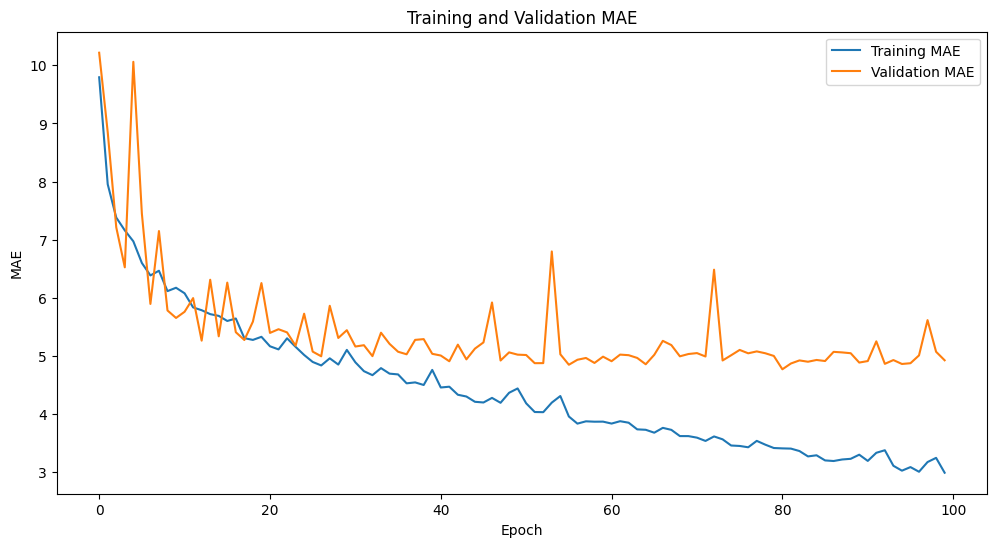

Test Loss: 47.63433837890625
Test MAE: 4.904817581176758


In [6]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True) 
train_model(model)

In [10]:
from tensorflow.keras.models import load_model
model = load_model('best_mae_age.h5')  # Ağırlıklar mevcut model nesnesine yüklendi
evaluate_model(model)


Test Loss: 46.30653762817383
Test MAE: 4.77794075012207
